In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np
import csv

np.set_printoptions(precision=10)
import sys
import random
from random import seed
from random import randint
from sklearn.metrics import accuracy_score
from bs4 import BeautifulSoup

from random import randrange

from scipy.special import expit
from scipy.special import softmax

pd.option_context('display.max_rows', None, 'display.max_columns', None)  # more options can be specified also
np.set_printoptions(threshold=sys.maxsize)
seed(1)

np.set_printoptions(precision=10, )
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)

%precision 10
!cp -r /content/drive/MyDrive/10601_DataSets /content

'''
We will be using a subset of an Optical Character Recognition (OCR) dataset. This data includes
images of all 26 handwritten letters; our subset will include only the letters “a,” “e,” “g,” “i,” “l,” “n,” “o,”
“r,” “t,” and “u.” 
The handout contains three datasets drawn from this data: 
a small dataset with 60 samples per class (50 for training and 10 for test), 
a medium dataset with 600 samples per class (500 for training and 100 for test), and 
a large dataset with 1000 samples per class (900 for training and 100 for test).

File Format Each dataset (small, medium, and large) consists of two csv files—train and test. 

Each row contains 129 columns separated by commas. 

The first column contains the label and columns 2 to 129 represent the pixel values of 
a 16 x 8 image in a row major format. 

Label 0 corresponds to “a,” 1 to “e,” 2 to “g,” 3 to “i,” 4 to “l,” 5 to “n,” 6 to “o,” 7 to “r,” 8 to “t,” and 9 to “u.” 

Because the original images are black-and-white (not grayscale), the pixel values are either 0 or 1. 
However, you should write your code to accept arbitrary pixel values in the range [0,1]. 

Observe that no feature engineering has been done here; instead the neural network you build
will learn features appropriate for the task of character recognition.
'''

'\nWe will be using a subset of an Optical Character Recognition (OCR) dataset. This data includes\nimages of all 26 handwritten letters; our subset will include only the letters “a,” “e,” “g,” “i,” “l,” “n,” “o,”\n“r,” “t,” and “u.” \nThe handout contains three datasets drawn from this data: \na small dataset with 60 samples per class (50 for training and 10 for test), \na medium dataset with 600 samples per class (500 for training and 100 for test), and \na large dataset with 1000 samples per class (900 for training and 100 for test).\n\nFile Format Each dataset (small, medium, and large) consists of two csv files—train and test. \n\nEach row contains 129 columns separated by commas. \n\nThe first column contains the label and columns 2 to 129 represent the pixel values of \na 16 x 8 image in a row major format. \n\nLabel 0 corresponds to “a,” 1 to “e,” 2 to “g,” 3 to “i,” 4 to “l,” 5 to “n,” 6 to “o,” 7 to “r,” 8 to “t,” and 9 to “u.” \n\nBecause the original images are black-and-wh

In [2]:
!tar -xf /content/10601_DataSets/HW5/handout.tar

In [63]:
large_test = pd.read_csv('/content/handout/largeTest.csv', sep= ',', header=None)
large_train = pd.read_csv('/content/handout/largeTrain.csv', sep= ',', header=None)

print("Training data shape: ", large_train.shape)
print("test data shape: ", large_test.shape)

large_test.rename(columns={0:'Label'}, inplace=True)
large_train.rename(columns={0:'Label'}, inplace=True)

Training data shape:  (9000, 129)
test data shape:  (1000, 129)


In [64]:
def weight_init(choice, height, width):
  if choice == "RANDOM":
    return np.random.uniform(low=-0.1, high=0.1, size=(height, width))
  else:
    return np.zeros([height, width])

In [5]:
def NNForward(train_example, train_label, alpha_train, beta_train):
  a = LinearForward(alpha_train, train_example)
  z = SigmoidForward(a)
  
  z_biased = np.vstack((1, z))
  b = LinearForward(beta_train, z_biased)

  y_hat = SoftmaxForward(b)
  J = CrossEntropyForward(train_label, y_hat)

  ForwardProp = {}

  ForwardProp['train_example'] = train_example
  ForwardProp['train_label'] = train_label

  ForwardProp['LinearForward_1'] = a
  ForwardProp['SigmoidForward'] = z

  ForwardProp['SigmoidForward_biased'] = z_biased
  ForwardProp['LinearForward_2'] = b

  ForwardProp['SoftmaxForward'] = y_hat
  ForwardProp['CrossEntropyForward'] = J
  return ForwardProp

In [6]:
def NNBackward(train_example, train_label, alpha_train, beta_train, properties):

  x = properties['train_example']
  y_true = properties['train_label']
  
  a = properties['LinearForward_1']
  z = properties['SigmoidForward']

  z_biased = properties['SigmoidForward_biased']
  b = properties['LinearForward_2']

  y_hat = properties['SoftmaxForward']
  J = properties['CrossEntropyForward']

  gj = 1

  g_yhat = CrossEntropyBackward(y_true, y_hat, J, gj)
  
  gb = SoftmaxBackward(b, y_hat, g_yhat)
  
  g_beta, gz = LinearBackward(z_biased, beta_train, gb.T)
  ga = SigmoidBackward(z, gz)

  g_alpha, _ = LinearBackward(x, a, ga)

  return g_alpha, g_beta

In [44]:
def calc_cross_entropy(y_pred_mat, y_true_mat):

  log_predictions = np.log(y_pred_mat)
  multi = np.multiply(log_predictions, y_true_mat)
  summation = multi.sum(axis = 1)
  summation = -1 * summation.sum(axis = 0) / y_true_mat.shape[0]
  print("Cross entropy: ", summation)
  return summation

In [8]:
def SigmoidForward(a):
  # shape: D x 1 or K x 1
  b = expit(a)
  return b

def SigmoidBackward(z, gz):
  ga = np.multiply(np.multiply(gz, z), (1 - z))
  return ga

def SoftmaxForward(a):
  # k x 1
  b = softmax(a)
  return b

def SoftmaxBackward(a, b, gb):

  diag_b = np.multiply(np.identity(a.shape[0]), b)

  ga = np.dot(gb.T, (diag_b - np.dot(b, b.T)))
  
  return ga

In [9]:
def LinearForward(w, x):
  # b     =   (weights)     *    X(input)
  # D x 1 = D x (M + 1) * (M + 1) x 1
  # k x 1 = k x (D + 1) * (D + 1) x 1
  assert w.shape[1] == x.shape[0], "LinearForward error in shape"
  b = np.dot(w, x)
  return b

def LinearBackward(a, w, gb):
  assert gb.shape[1] == a.T.shape[0], "Error in LinearBackward"
  # gw = D x (M + 1) = (D x 1) * (1 x (M + 1))
  # gw = k x (D + 1) = (k x 1) * (1 x (D +1))
  gw = np.dot(gb, a.T)
  ga = np.dot(w[:,1:].T, gb)

  return gw, ga

In [10]:
def CrossEntropyForward(a, a_hat):
  # out = 1 x 1 = (1 x k) * (k x 1)
  assert a.shape[0] == a_hat.shape[0], "Error in CrossEntropyForward"
  b = -1 * np.dot(a.T, a_hat)
  return b

def CrossEntropyBackward(a, a_hat, b, gb):
  # Return K x 1 vector
  ga_hat = -gb * (a / a_hat)

  assert a.shape[0] == a_hat.shape[0], "Error in output shape in CrossEntropyForward"
  assert ga_hat.shape[0] != 1
  return ga_hat

In [65]:
def SGD_Procedure(df_train, df_test, epochs, learning_rate, 
                  num_classes, num_features, num_hidden,
                  weight_init_method):
  
  alpha = weight_init(weight_init_method, num_hidden, num_features)
  beta = weight_init(weight_init_method, num_classes, num_hidden)
  
  alpha = np.hstack((np.zeros((num_hidden, 1)), alpha))
  beta = np.hstack((np.zeros((num_classes, 1)), beta))
  
  cross_test_list = []
  cross_train_list = []

  for epoch in range(0, epochs):
    
    arr_true = 0
    arr_pred = 0
    arr_test = 0
    arr_true_test = 0
    flag = 0

    print("EPOCH NUMBER: ", epoch)
    for index, row in df_train.iterrows():
      
      # Training example and label
      label = row['Label']
      tr_label = np.zeros([num_classes, 1])
      tr_label[label] = 1

      exmp = np.array(row.to_numpy().reshape(129, 1))
      exmp[0] = 1
      
      # Forward probagation for train example
      forward_result = NNForward(exmp, tr_label, alpha, beta)
      
      # Backward probagation for train example
      grad_alpha, grad_beta = NNBackward(exmp, tr_label, alpha, beta, forward_result)
      
      if flag == 0:
        arr_true = tr_label.reshape(1, 10)
        arr_pred = forward_result['SoftmaxForward'].reshape(1, 10)
      else:
        arr_true = np.vstack((tr_label.reshape(1, 10), arr_true))
        arr_pred = np.vstack((forward_result['SoftmaxForward'].reshape(1, 10), arr_pred))

      if index < df_test.shape[0]:
        # Test example and label
        ts_label = large_test.iloc[index]['Label']
        ts_label_arr = np.zeros([num_classes, 1])
        ts_label_arr[ts_label] = 1

        exmp_test = np.array(large_test.iloc[index].to_numpy().reshape(129, 1))
        exmp_test[0] = 1

        # Forward probagation for test example
        forward_result = NNForward(exmp_test, ts_label_arr, alpha, beta)

        if flag == 0:
          arr_true_test = ts_label_arr.reshape(1, 10)
          arr_test = forward_result['SoftmaxForward'].reshape(1, 10)
        else:
          arr_true_test = np.vstack((ts_label_arr.reshape(1, 10), arr_true_test))
          arr_test = np.vstack((forward_result['SoftmaxForward'].reshape(1, 10), arr_test))

      alpha = alpha - learning_rate * grad_alpha
      beta = beta -  learning_rate * grad_beta

      flag += 1

    print("Train cross entropy: ")
    cross_train_list.append(calc_cross_entropy(arr_pred, arr_true))
    print("Test cross entropy: ")
    cross_test_list.append(calc_cross_entropy(arr_test, arr_true_test))

  return alpha, beta, cross_test_list, cross_train_list

a, b, test_cross, train_cross = SGD_Procedure(df_train=large_train, df_test=large_test, epochs=100,
                                              learning_rate=0.01, num_classes=10, num_features=128, 
                                              num_hidden=50, weight_init_method="RANDOM")

EPOCH NUMBER:  0
Train cross entropy: 
Cross entropy:  1.5491689117963687
Test cross entropy: 
Cross entropy:  2.3067683045163623
EPOCH NUMBER:  1
Train cross entropy: 
Cross entropy:  0.8008735532431688
Test cross entropy: 
Cross entropy:  0.98738219902266
EPOCH NUMBER:  2
Train cross entropy: 
Cross entropy:  0.6547942815189282
Test cross entropy: 
Cross entropy:  0.7640717935782677
EPOCH NUMBER:  3
Train cross entropy: 
Cross entropy:  0.5864879268597702
Test cross entropy: 
Cross entropy:  0.685416176650667
EPOCH NUMBER:  4
Train cross entropy: 
Cross entropy:  0.5410140956579285
Test cross entropy: 
Cross entropy:  0.6390782342511377
EPOCH NUMBER:  5
Train cross entropy: 
Cross entropy:  0.5063375433963474
Test cross entropy: 
Cross entropy:  0.606333293228794
EPOCH NUMBER:  6
Train cross entropy: 
Cross entropy:  0.4778596263942346
Test cross entropy: 
Cross entropy:  0.581025086132742
EPOCH NUMBER:  7
Train cross entropy: 
Cross entropy:  0.4534004935674604
Test cross entropy: 


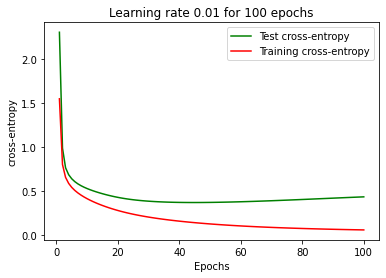

In [71]:
epochs = [i for i in range(1, 101)]
plt.title('Learning rate 0.01 for 100 epochs')
plt.xlabel("Epochs")
plt.ylabel("cross-entropy")
plt.plot(epochs, test_cross, color='green', label='Test cross-entropy')
plt.plot(epochs, train_cross, color='red', label='Training cross-entropy')
plt.legend()
plt.show()

In [72]:
a, b, test_cross, train_cross = SGD_Procedure(df_train=large_train, df_test=large_test, epochs=100,
                                              learning_rate=0.1, num_classes=10, num_features=128, 
                                              num_hidden=50, weight_init_method="RANDOM")

EPOCH NUMBER:  0
Train cross entropy: 
Cross entropy:  0.7778926234153062
Test cross entropy: 
Cross entropy:  1.7678600764697663
EPOCH NUMBER:  1
Train cross entropy: 
Cross entropy:  0.4408360906332462
Test cross entropy: 
Cross entropy:  0.5564148846369601
EPOCH NUMBER:  2
Train cross entropy: 
Cross entropy:  0.3433878540833942
Test cross entropy: 
Cross entropy:  0.4718189691158607
EPOCH NUMBER:  3
Train cross entropy: 
Cross entropy:  0.28195680001294154
Test cross entropy: 
Cross entropy:  0.4368180754333896
EPOCH NUMBER:  4
Train cross entropy: 
Cross entropy:  0.23799635106194714
Test cross entropy: 
Cross entropy:  0.4278007138540913
EPOCH NUMBER:  5
Train cross entropy: 
Cross entropy:  0.2031256946119844
Test cross entropy: 
Cross entropy:  0.4313045852498812
EPOCH NUMBER:  6
Train cross entropy: 
Cross entropy:  0.17498181548299152
Test cross entropy: 
Cross entropy:  0.43808275248037254
EPOCH NUMBER:  7
Train cross entropy: 
Cross entropy:  0.15140009013039404
Test cross 

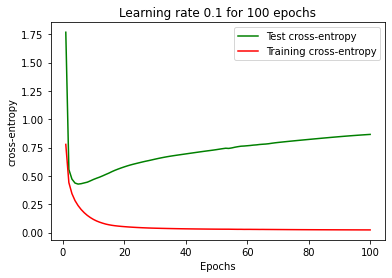

In [73]:
epochs = [i for i in range(1, 101)]
plt.title('Learning rate 0.1 for 100 epochs')
plt.xlabel("Epochs")
plt.ylabel("cross-entropy")
plt.plot(epochs, test_cross, color='green', label='Test cross-entropy')
plt.plot(epochs, train_cross, color='red', label='Training cross-entropy')
plt.legend()
plt.show()

In [74]:
a, b, test_cross, train_cross = SGD_Procedure(df_train=large_train, df_test=large_test, epochs=100,
                                              learning_rate=0.001, num_classes=10, num_features=128, 
                                              num_hidden=50, weight_init_method="RANDOM")

EPOCH NUMBER:  0
Train cross entropy: 
Cross entropy:  2.283726656517473
Test cross entropy: 
Cross entropy:  2.3147929995710745
EPOCH NUMBER:  1
Train cross entropy: 
Cross entropy:  2.1914946391191767
Test cross entropy: 
Cross entropy:  2.24835502560421
EPOCH NUMBER:  2
Train cross entropy: 
Cross entropy:  1.9972446785019653
Test cross entropy: 
Cross entropy:  2.1072569293382366
EPOCH NUMBER:  3
Train cross entropy: 
Cross entropy:  1.7551398550752362
Test cross entropy: 
Cross entropy:  1.8698623243241261
EPOCH NUMBER:  4
Train cross entropy: 
Cross entropy:  1.549971578110816
Test cross entropy: 
Cross entropy:  1.6490933234141532
EPOCH NUMBER:  5
Train cross entropy: 
Cross entropy:  1.3823367946196201
Test cross entropy: 
Cross entropy:  1.4724367266385583
EPOCH NUMBER:  6
Train cross entropy: 
Cross entropy:  1.2426226353712242
Test cross entropy: 
Cross entropy:  1.3267684764642111
EPOCH NUMBER:  7
Train cross entropy: 
Cross entropy:  1.1281632338416405
Test cross entropy: 

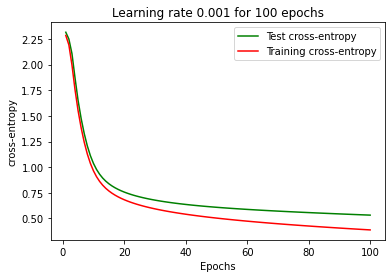

In [75]:
epochs = [i for i in range(1, 101)]
plt.title('Learning rate 0.001 for 100 epochs')
plt.xlabel("Epochs")
plt.ylabel("cross-entropy")
plt.plot(epochs, test_cross, color='green', label='Test cross-entropy')
plt.plot(epochs, train_cross, color='red', label='Training cross-entropy')
plt.legend()
plt.show()

In [82]:
final_values_test = []
final_values_train = []

for num in [5, 20, 50, 100, 200]:
  a, b, test_cross, train_cross = SGD_Procedure(df_train=large_train, df_test=large_test, epochs=100,
                                              learning_rate=0.01, num_classes=10, num_features=128, 
                                              num_hidden=num, weight_init_method="RANDOM")
  final_values_test.append(test_cross)
  final_values_train.append(train_cross)

EPOCH NUMBER:  0
Train cross entropy: 
Cross entropy:  1.9676189449734933
Test cross entropy: 
Cross entropy:  2.30408203650467
EPOCH NUMBER:  1
Train cross entropy: 
Cross entropy:  1.409322513152607
Test cross entropy: 
Cross entropy:  1.5622509136830818
EPOCH NUMBER:  2
Train cross entropy: 
Cross entropy:  1.1552319232063888
Test cross entropy: 
Cross entropy:  1.2814075254366315
EPOCH NUMBER:  3
Train cross entropy: 
Cross entropy:  0.9693046187899463
Test cross entropy: 
Cross entropy:  1.0837548299093325
EPOCH NUMBER:  4
Train cross entropy: 
Cross entropy:  0.8525793310507292
Test cross entropy: 
Cross entropy:  0.947785957727688
EPOCH NUMBER:  5
Train cross entropy: 
Cross entropy:  0.791697963847689
Test cross entropy: 
Cross entropy:  0.8759559997465154
EPOCH NUMBER:  6
Train cross entropy: 
Cross entropy:  0.7560228529001787
Test cross entropy: 
Cross entropy:  0.8373288938862029
EPOCH NUMBER:  7
Train cross entropy: 
Cross entropy:  0.7323824601696517
Test cross entropy: 


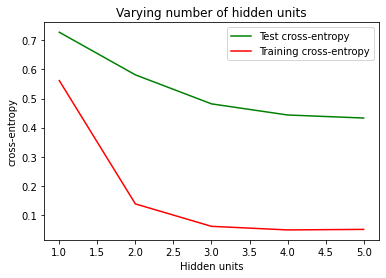

In [87]:
tmp_test = []
tmp_train = []
for value in final_values_test:
  tmp_test.append(value[99])

for value in final_values_train:
  tmp_train.append(value[99])

epochs = [i for i in range(1, 6)]
plt.title('Varying number of hidden units')
plt.xlabel("Hidden units")
plt.ylabel("cross-entropy")
plt.plot(epochs, tmp_test, color='green', label='Test cross-entropy')
plt.plot(epochs, tmp_train, color='red', label='Training cross-entropy')
plt.legend()
plt.show()